In [2]:
import torch
import lightning
from mlcolvar.cvs import BaseCV
from mlcolvar.core import FeedForward

__all__ = ["Generator"]
torch.manual_seed(42)
torch.set_default_dtype(torch.float64)


## Load data

In [3]:
import numpy as np
from mlcolvar.data import DictModule, DictDataset
from mlcolvar.utils.io import create_dataset_from_files, load_dataframe
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
opes = load_dataframe('../data/COLVAR_tetrapeptide',
                      start=50000,stop=None, stride=1)



/home/tdevergne@iit.local/anaconda3/envs/kooplearn-reborn/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Define common variables

In [4]:

X = opes.filter(regex='p[0-9]\.[abc]|p[0-9][0-9]\.[abc]')
kT = 2.49432
logweights = opes["opes.bias"] / kT
weights = np.exp(logweights)
weights/=weights.mean()
dataset = DictDataset({"data":X.values, "weights":weights})#30 2500 epochs


In [5]:
dataset["data"] = dataset["data"].to(device)
dataset["weights"] = dataset["weights"].to(device)

In [6]:
masses = np.array([12.011,12.011,15.999,14.0067,12.011,12.011,12.011,15.999,14.0067,12.011,12.011,12.011,15.999,14.0067,12.011,12.011,12.011,15.999,14.0067,12.011,12.011,12.011,15.999,14.0067,12.011])
n_atoms = 20
gamma = 1/0.05
friction = np.zeros(n_atoms*3)
print(friction.shape)
for i_atom in range(20):
    friction[3*i_atom:3*i_atom+3] = np.array([kT / (gamma*masses[i_atom])]*3) 
cell = torch.Tensor([4.0,4.0,4.0]).to(device)
#cell = torch.ones(91*3).to(device)*3.961
friction = torch.tensor(friction, device=device)

(60,)


## Descriptors computation

In [7]:
from mlcolvar.core.transform.descriptors import TorsionalAngle
from mlcolvar.core.transform import MultipleDescriptors
cell= torch.Tensor([4.0,4.0,4.0]).to(device)
#list_angles = [[1,3,4,6],[3,4,6,8],[6,8,9,11],[8,9,11,13],[11,13,14,16],[13,14,16,18]]
list_angles = [[6,8,9,11],[11,13,14,16]]
ComputeAngles1=TorsionalAngle(indices=list_angles[0],mode=["sin","cos"],PBC=True,cell=cell,scaled_coords=True,n_atoms=20)
ComputeAngles2=TorsionalAngle(indices=list_angles[1],mode=["sin","cos"],PBC=True,cell=cell,scaled_coords=True,n_atoms=20)
descriptors =  MultipleDescriptors(descriptors_list=[ComputeAngles1,ComputeAngles2], n_atoms=20)



In [8]:
from mlcolvar.core.loss.committor_loss import SmartDerivatives, compute_descriptors_derivatives
dataset["labels"] = torch.ones_like(dataset["weights"])

pos, desc, d_desc_d_pos = compute_descriptors_derivatives(dataset, descriptors, n_atoms, separate_boundary_dataset = False)

dataset = DictDataset({"data":desc.clone().detach().to(device), "weights":dataset["weights"],"derivatives":d_desc_d_pos.clone().detach().to(device)})#30 2500 epochs
datamodule = DictModule(dataset, lengths=[0.8,0.2])


## Model definition

In [9]:
from mlcolvar.cvs.generator import Generator
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR
cell1 = torch.ones(20*3).to(device)*4.00

options = { 'nn':{'activation':'tanh'},

            'optimizer' : {'lr': 1e-3, 'weight_decay': 1e-5}}
model = Generator(layers=[4,20,20,1],eta=0.1,r=6,cell=cell1,alpha=5,friction=friction, options=options)


In [10]:
model = model.to(device)

## Train the model (the result of the training is provided below)

In [ ]:
# define callbacks
from mlcolvar.utils.trainer import MetricsCallback
from lightning.pytorch.callbacks import ModelCheckpoint

import wandb
from lightning.pytorch.loggers import WandbLogger
wandb_logger = WandbLogger(project='tetrapeptide_angles')

# add your batch size to the wandb config
#wandb_logger.experiment.config["batch_size"] = batch_size
metrics = MetricsCallback()
checkpoint_callback = ModelCheckpoint(dirpath="/home/devergne/checkpoints_tetrapeptide_angles_tetrapeptide",every_n_train_steps=100,save_top_k=-1)
# initialize trainer, for testing the number of epochs is low, change this to something like 4/5000
trainer = lightning.Trainer(callbacks=[metrics,checkpoint_callback],#,early_stop_callback], 
                            max_epochs=30000, 
                            logger=wandb_logger,

                            enable_checkpointing=True,
                            enable_progress_bar=False
                            
                            )
# fit model
trainer.fit(model, datamodule)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f1796f917c0>>
Traceback (most recent call last):
  File "/home/tdevergne@iit.local/anaconda3/envs/kooplearn-reborn/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tim

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | loss_fn | GeneratorLoss | 6      | ?        | ?        
1 | nn      | ModuleList    | 3.2 K  | ?        | ?        
-----------------------------------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)
/home/tdevergne@iit.local/anaconda3/envs/kooplearn-reborn/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


## Load weights

In [11]:

model1= torch.load("models/model_tetrapeptide.pt")
model = Generator(layers=[4,20,20,1],eta=0.1,r=6,cell=cell1,alpha=5,friction=friction, options=options)
model.load_state_dict(model1)
model.to(device)

Generator(
  (loss_fn): GeneratorLoss()
  (nn): ModuleList(
    (0): FeedForward(
      (nn): Sequential(
        (0): Linear(in_features=4, out_features=20, bias=True)
        (1): Tanh()
        (2): Linear(in_features=20, out_features=20, bias=True)
        (3): Tanh()
        (4): Linear(in_features=20, out_features=1, bias=True)
      )
    )
    (1): FeedForward(
      (nn): Sequential(
        (0): Linear(in_features=4, out_features=20, bias=True)
        (1): Tanh()
        (2): Linear(in_features=20, out_features=20, bias=True)
        (3): Tanh()
        (4): Linear(in_features=20, out_features=1, bias=True)
      )
    )
    (2): FeedForward(
      (nn): Sequential(
        (0): Linear(in_features=4, out_features=20, bias=True)
        (1): Tanh()
        (2): Linear(in_features=20, out_features=20, bias=True)
        (3): Tanh()
        (4): Linear(in_features=20, out_features=1, bias=True)
      )
    )
    (3): FeedForward(
      (nn): Sequential(
        (0): Linear(in_f

## Compute eigenfunctions

In [12]:
eigenfunctions, evals, evecs = model.compute_eigenfunctions(dataset,tikhonov_reg=1e-4)

## Build classification 
Note that here we used the values of angles to build the classification, but the sign of the eigenfunctions can be used

In [13]:
def classify_points(array):
    # Initialize classification to 10
    classification = np.ones(array.shape[0], dtype=int) * 10
    
    # Create masks for each condition
    mask_0 = ((array[:, 0] < -0.1) | (array[:, 0] > 2.0)) & \
             ((array[:, 1] < -0.1) | (array[:, 1] > 2.0)) 
    mask_1 = ((array[:, 0] > 0.1) & (array[:, 0] < 2.0)) & \
             ((array[:, 1] < -0.1) | (array[:, 1] > 2.0)) 
    mask_2 = ((array[:, 0] < -0.1) | (array[:, 0] > 2.0)) & \
             ((array[:, 1] > 0.1) & (array[:, 1] < 2.0)) 

    mask_3 = ((array[:, 0] > 0.1) & (array[:, 0] < 2.0)) & \
             ((array[:, 1] > 0.1) & (array[:, 1] < 2.0)) 

    # Assign classifications based on conditions
    classification[mask_0] = 0
    classification[mask_1] = 1
    classification[mask_2] = 2
    classification[mask_3] = 3
    
    # Optionally, convert classification to "Condition X" format    
    # Return classification labels (replace numerical classifications)
    return classification
# Example usage



## Put eigenvalues in units of 1/gamma


In [14]:
evals = evals*0.05

In [15]:
evals

tensor([-5.0689e-06+0.j, -1.6196e-05+0.j, -3.0707e-05+0.j, -9.1751e-05+0.j,
        -4.2226e-01+0.j, -6.4819e-01+0.j], device='cuda:0')

## Build classification and forecast state occupation

In [16]:
from mlcolvar.core.loss.generator_loss import forecast_state_occupation
start = 200  # A small positive number to avoid log(0)
end = 700000
num_points = 100  # Adjust the number of points as needed

# Create the logarithmically spaced array
times = torch.logspace(np.log10(start), np.log10(end), num_points,device=device)
angles = np.stack((opes["phi2"],opes["phi3"])).T
classification = torch.tensor(classify_points(angles),device=device)
evals[0]=0
#evals *= 0.05
occupation = forecast_state_occupation(eigenfunctions, evals, times, classification, dataset["weights"],4)

In [17]:
occupation.shape

torch.Size([4, 4, 100])

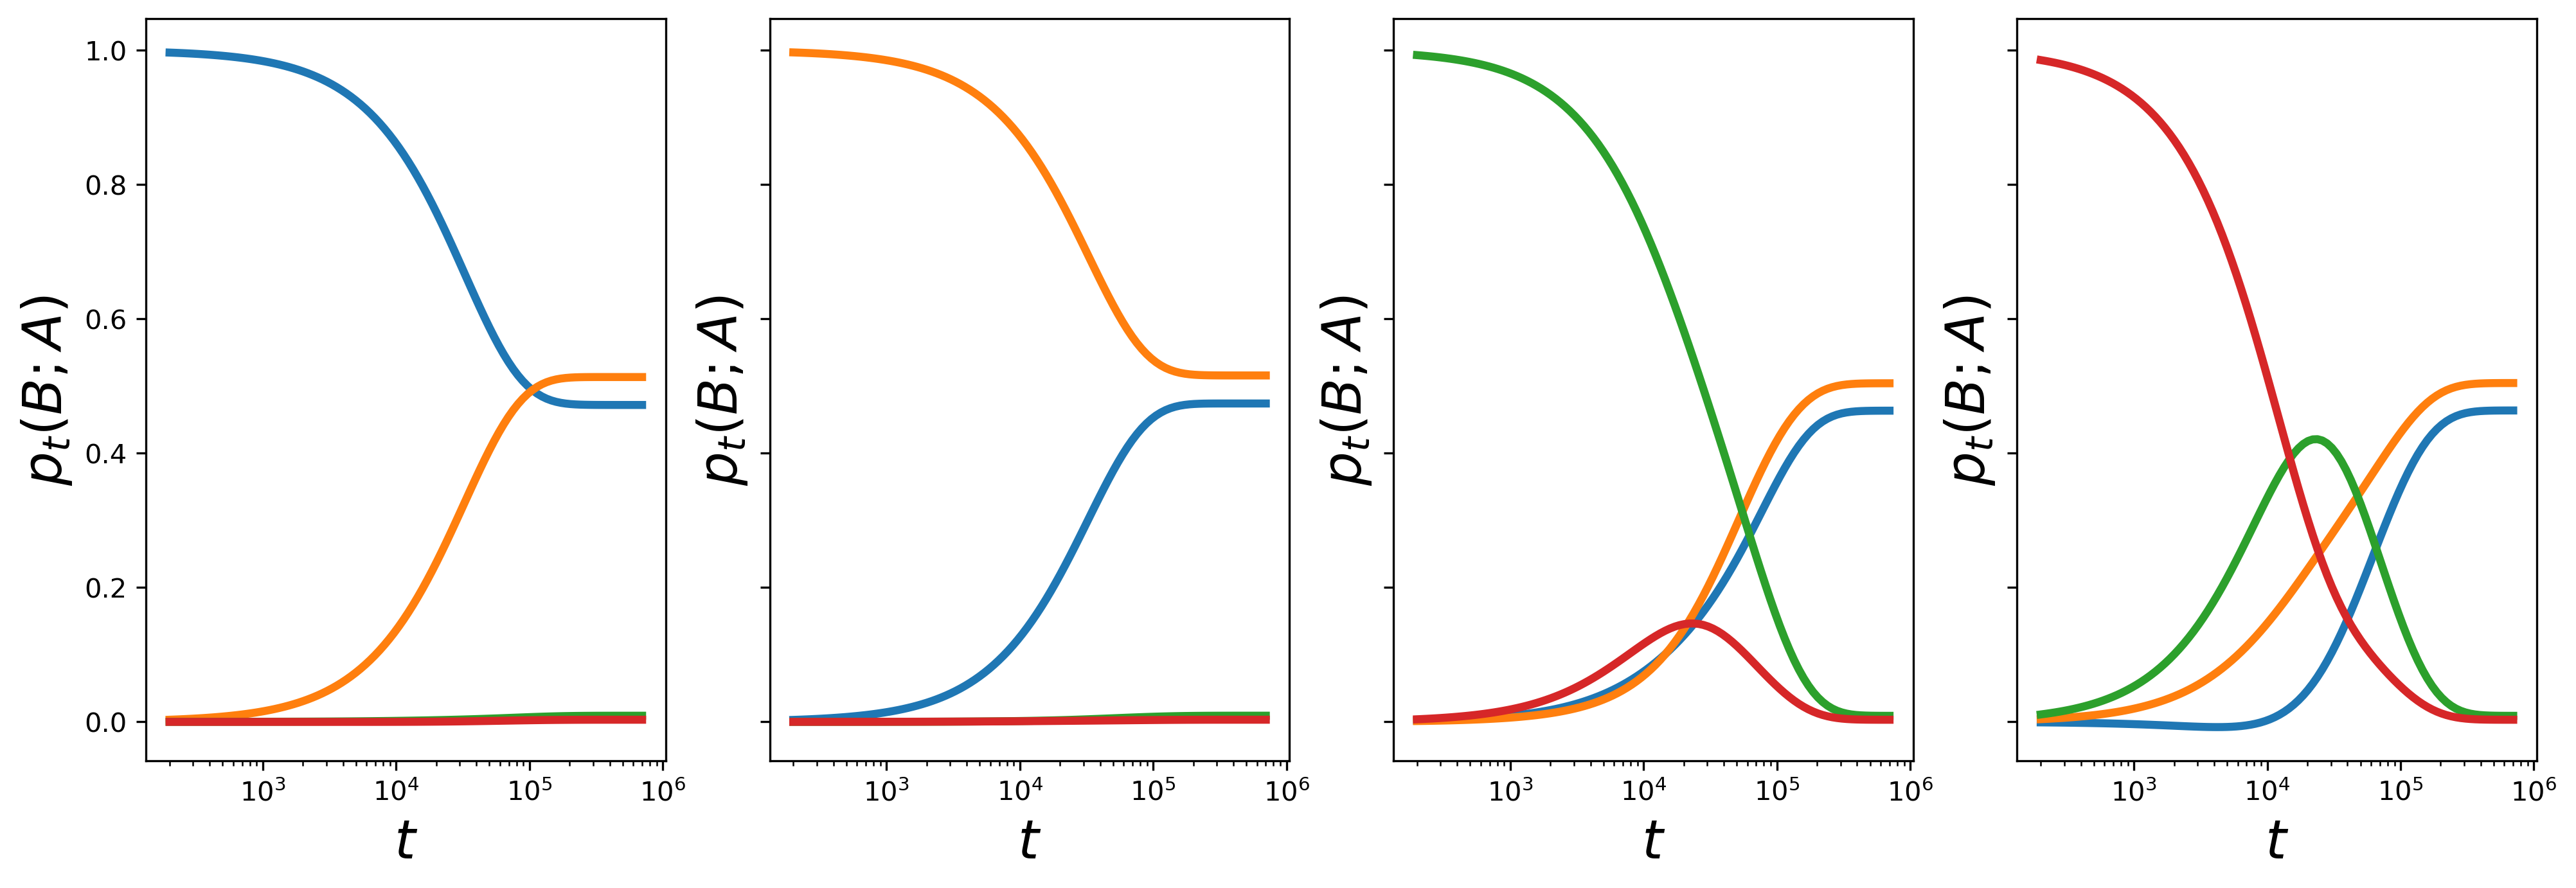

In [18]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 4, figsize=(16, 5), dpi=300, sharey=True)
for initial_state in range(4):
    ax = axs[initial_state]
    for final_state in range(4):
        ax.plot(times.cpu().detach(), occupation[initial_state,final_state].cpu().detach(),linewidth=3)
        ax.set_xscale("log")
    ax.set_xlabel(r"$t$",fontsize=20)
    ax.set_ylabel(r"$p_t(B;A)$",fontsize=20)
